<a href="https://colab.research.google.com/github/jecampagne/ML-toys/blob/main/Test_SBI_Pytorch_SimpleExo_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.7.14


In [1]:
!pip install --upgrade --quiet sbi

     |████████████████████████████████| 293 kB 6.9 MB/s 
     |████████████████████████████████| 722 kB 39.5 MB/s 
     |████████████████████████████████| 45 kB 3.6 MB/s 


In [2]:
!pip uninstall -y matplotlib
!pip install -q matplotlib==3.5.0
# Re-init the environment

Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2
     |████████████████████████████████| 11.2 MB 5.1 MB/s 
     |████████████████████████████████| 42 kB 393 kB/s 
     |████████████████████████████████| 960 kB 46.1 MB/s 


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

print(mpl.__version__)

3.5.0


In [2]:
import torch
import numpy as np

from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
import pyro
pyro.set_rng_seed(0)

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [22]:
cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [23]:
mkdir SBIimg

In [26]:
! cd /content/gdrive/MyDrive/SBIimg

In [33]:
import arviz as az
import matplotlib.patches as mpatches

def overplot_lines(axes, xs, reverse=False, **kwargs):
    """
    Overplot lines on a figure generated by ``corner.corner``
    Parameters
    ----------
    fig : Figure
        The figure generated by a call to :func:`corner.corner`.
    xs : array_like[ndim]
       The values where the lines should be plotted. This must have ``ndim``
       entries, where ``ndim`` is compatible with the :func:`corner.corner`
       call that originally generated the figure. The entries can optionally
       be ``None`` to omit the line in that axis.
    reverse: bool
       A boolean flag that should be set to 'True' if the corner plot itself
       was plotted with 'reverse=True'.
    **kwargs
        Any remaining keyword arguments are passed to the ``ax.axvline``
        method.
    """
    K = len(xs)
    if reverse:
        for k1 in range(K):
            if xs[k1] is not None:
                axes[K - k1 - 1, K - k1 - 1].axvline(xs[k1], **kwargs)
            for k2 in range(k1 + 1, K):
                if xs[k1] is not None:
                    axes[K - k2 - 1, K - k1 - 1].axvline(xs[k1], **kwargs)
                if xs[k2] is not None:
                    axes[K - k2 - 1, K - k1 - 1].axhline(xs[k2], **kwargs)

    else:
        for k1 in range(K):
            if xs[k1] is not None:
                axes[k1, k1].axvline(xs[k1], **kwargs)
            for k2 in range(k1 + 1, K):
                if xs[k1] is not None:
                    axes[k2, k1].axvline(xs[k1], **kwargs)
                if xs[k2] is not None:
                    axes[k2, k1].axhline(xs[k2], **kwargs)

def plot_params_kde(samples,hdi_probs=[0.393, 0.865, 0.989], 
                    patName=None, fname=None, pcut=None, reference_values=None, 
                    reference_color='k', label_size=10,labeller=None, limits=None,
                   var_names=None, point_estimate="median", figsize=(8,8)):
    """
     limts = [[min_1,max_1], ... , [min_N, max_N]] N varaibles
    """
        
    if pcut is not None:
        low = pcut[0]
        up  = pcut[1] 
        #keep only data in the [low, up] percentiles ex. 0.5, 99.5
        samples={name:value[(value>np.percentile(value,low)) &  (value<np.percentile(value,up))] \
          for name, value in samples.items()}
        len_min = np.min([len(value) for name, value in samples.items()])
        len_max = np.max([len(value) for name, value in samples.items()])
        if (len_max-len_min)>0.01*len_max:
            print(f"Warning: pcut leads to min/max spls size = {len_min}/{len_max}")
        samples = {name:value[:len_min] for name, value in samples.items()}
    
    axs= az.plot_pair(
            samples,
            var_names=var_names,
            kind="kde",
            labeller=labeller,
            figsize=figsize,
            marginal_kwargs={"plot_kwargs": {"linewidth": 2, "c": "b"}},
            kde_kwargs={
#                "hdi_probs": [0.68, 0.9],  # Plot 68% and 90% HDI contours
                "hdi_probs":hdi_probs,  # 1, 2 and 3 sigma contours
                "contour_kwargs":{"colors":('r', 'green', 'blue'), "linewidth":2},
                "contourf_kwargs":{"alpha":0},
            },
            point_estimate_kwargs={"lw": 2, "c": "b"},
            marginals=True, textsize=label_size, point_estimate=point_estimate,
            reference_values=reference_values, reference_values_kwargs={"c":reference_color}
        );
    
    if reference_values is not None:
      overplot_lines(axs,list(reference_values.values()), color=reference_color)
      if limits is not None:
        assert len(limits) == len(samples.keys()), "wrong number of limits"
        for i in range(0,axs.shape[0]):
          for j in range(0,i+1):
            if j == i:
              axs[i,i].set_xlim(limits[i])
            else:
              axs[i,j].set_xlim(limits[j])
              axs[i,j].set_ylim(limits[i])

    plt.tight_layout()
    
    if patName is not None:
#        patName_patch = mpatches.Patch(color='b', label=patName)
#        axs[0,0].legend(handles=[patName_patch], fontsize=40, bbox_to_anchor=(1, 0.7));
      fig = axs[0,0].get_figure()
      fig.suptitle(patName)
    if fname is not None:
        plt.savefig(fname)
        plt.close()




In [7]:
#Let us define a common uniform prior for each parameter
theta_dim = 3
prior = utils.BoxUniform(low=-5 * torch.ones(theta_dim), high=5 * torch.ones(theta_dim))


In [8]:
#Here a way to implement the simulator using pyro
import pyro.distributions as dist
def simulator(theta):
  x = pyro.sample("x", dist.Normal(theta, 0.1))
  return x

#notice that for this simple exemple one may have done like
#def simulator(theta):
#  return theta + 0.1* torch.randn_like(theta)

In [9]:
#Here is the output of the simulator for a set of parameters
simulator(torch.tensor([1.0, -1.0, 1.5]))

tensor([ 1.1541, -1.0293,  1.2821])

# 1 round Optimisation

In [10]:
# Let us define one observation of the following true underlaying theta param
true_theta = np.array([2.0, -1.5, 0.5])
x_o = simulator(torch.tensor(true_theta))[None]

In [11]:
x_o

tensor([[ 2.0568, -1.6085,  0.3601]], dtype=torch.float64)

In [12]:
#adapt/check the prior & simulator for SBI
simulator, prior = prepare_for_sbi(simulator, prior)

In [29]:
keys = ["t"+str(i) for i in range(theta_dim)]
obs = dict(zip(keys,x_o.numpy().squeeze()))
#truth = dict(zip(keys,true_theta))


In [36]:
for name in ["SNPE","SNLE","SNRE"]:
  print("Inference :",name)
  if name == "SNPE":
    inference = SNPE(prior=prior) #"SNPE" as SNPE_C 
  elif name == "SNLE":
    inference = SNLE(prior=prior) #"SNLE" as SNLE_A 
  elif name == "SNRE":
    infer_SNRE = SNRE(prior=prior) #"SNRE" as SNRE_B

  #siumlate
  num_sim = 1_000
  theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=num_sim)
  inference = inference.append_simulations(theta, x)
  #train the inference network/flow paramater
  density_estimator = inference.train()
  #build the posterior estimate p(theta|X)
  posterior = inference.build_posterior(density_estimator)
  #Sample the posterior with the constraint x=x_o
  if isinstance(inference,SNLE) or isinstance(inference,SNRE):
    spls = posterior.sample((10_000,), x=x_o, num_chains=100,  method="slice_np_vectorized")
  else:
    spls = posterior.sample((10_000,), x=x_o)  

  #plot
  values = [spls[:,i]for i in range(theta_dim)]
  data = dict(zip(keys,values))
  plot_params_kde(data,var_names=keys, figsize=(5,5), limits=None,
    point_estimate=None, reference_values=obs, reference_color='r',
    patName=name, fname='./'+name+'_1obs_1round.pdf');
  



Inference : SNPE


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 296 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)


Inference : SNLE


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 138 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/110000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)


Inference : SNRE


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 45 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/110000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)


# Multi rounds...

In [50]:
# multi rounds: first round simulates from the prior, second round simulates parameter set
# that were sampled from the obtained posterior.
num_rounds = 5
# The specific observation we want to focus the inference on is x_o (single)

simulator, prior = prepare_for_sbi(simulator, prior)
for name in ["SNPE","SNLE","SNRE"]:
  print("Inference :",name)
  if name == "SNPE":
    inference = SNPE(prior=prior) #"SNPE" as SNPE_C 
  elif name == "SNLE":
    inference = SNLE(prior=prior) #"SNLE" as SNLE_A 
  elif name == "SNRE":
    infer_SNRE = SNRE(prior=prior) #"SNRE" as SNRE_B

  posteriors = []
  proposal = prior

  for i in range(num_rounds):
    if i==0:
      theta, x = simulate_for_sbi(simulator, proposal, num_simulations=1000)
    else:
      if isinstance(inference,SNPE):
        theta = proposal.sample((1000,))
      else:
        theta = proposal.sample((1000,), method="slice_np_vectorized", num_chains=100)
      x = simulator(theta)

    # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    if isinstance(inference,SNPE):
      density_estimator = inference.append_simulations(
          theta, x, proposal=proposal
      ).train()
    else:
      density_estimator = inference.append_simulations(
          theta, x
      ).train()

    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)  
    proposal = posterior.set_default_x(x_o)

  # sample with tuned posterior
  if isinstance(inference,SNLE) or isinstance(inference,SNRE):
      spls = posterior.sample((10_000,), x=x_o, num_chains=100,  method="slice_np_vectorized")
  else:
      spls = posterior.sample((10_000,), x=x_o)  

  values = [spls[:,i]for i in range(theta_dim)]
  data = dict(zip(keys,values))
  plot_params_kde(data,var_names=keys, figsize=(5,5), limits=None,
      point_estimate=None, reference_values=obs, reference_color='r',
      patName=name, fname='./simple1_'+name+'_1obs_'+str(num_rounds)+'rounds.pdf');


Inference : SNPE


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 144 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 59 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 46 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)


Inference : SNLE


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 165 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

 Neural network successfully converged after 26 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

 Neural network successfully converged after 36 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

 Neural network successfully converged after 21 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

 Neural network successfully converged after 44 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/110000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)


Inference : SNRE


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 53 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

 Neural network successfully converged after 65 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

 Neural network successfully converged after 35 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

 Neural network successfully converged after 22 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

 Neural network successfully converged after 46 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/110000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)


# Direct True Likelihood  sampling

In [41]:
import pyro.distributions as dist

In [42]:
def wrapper_log_posterior(theta):
    theta = theta['t']
    dist = torch.distributions.Normal(loc=theta,
                            scale=torch.tensor([0.1]*len(theta)))

    log_post = dist.log_prob(x_o).sum() + prior.log_prob(theta).sum()
    return -log_post


In [43]:
kernel = pyro.infer.NUTS(
    potential_fn=wrapper_log_posterior,
)


In [44]:
num_chains = 1
mcmc = pyro.infer.MCMC(
        kernel,
        num_samples=10_000,
        warmup_steps=500,
        num_chains=num_chains,
        initial_params={'t': torch.zeros(size=(num_chains,theta_dim))}
)


In [45]:
mcmc.run()

Sample: 100%|██████████| 10500/10500 [00:52, 200.22it/s, step size=7.52e-01, acc. prob=0.919]


In [46]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    t[0,0]      2.06      0.10      2.06      1.89      2.22  10285.69      1.00
    t[0,1]     -1.61      0.10     -1.61     -1.77     -1.45   9993.35      1.00
    t[0,2]      0.36      0.10      0.36      0.19      0.52   8921.81      1.00

Number of divergences: 0


In [48]:
spls_0 = mcmc.get_samples()['t'].numpy().squeeze()
keys = ["t"+str(i) for i in range(theta_dim)]
values = [spls_0[:,i]for i in range(theta_dim)]
data_0 = dict(zip(keys,values))


In [49]:
plot_params_kde(data_0, figsize=(5,5),limits=None,
  point_estimate=None, reference_values=obs, reference_color='r',
  fname='./simple1_true_posterior.pdf');

/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)


# Use multi observation arround x_o with the multi-rounds posterior estimation

In [151]:
n_observations = 100
observations = torch.tensor(true_theta)[None]  + 0.1*torch.randn(n_observations, theta_dim)

In [152]:
spls_1 = posterior.sample((10_000,), x=observations, method="slice_np_vectorized", num_chains=100)

/usr/local/lib/python3.7/dist-packages/sbi/utils/sbiutils.py:285: UserWarning: An x with a batch size of 100 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  respect to entire batch, i.e,. p(theta | X)."""


Running vectorized MCMC with 100 chains:   0%|          | 0/110000 [00:00<?, ?it/s]

In [153]:
keys = ["t"+str(i) for i in range(theta_dim)]
values = [spls_1[:,i]for i in range(theta_dim)]
data_1 = dict(zip(keys,values))
truth = dict(zip(keys,true_theta))
obs = dict(zip(keys,x_o.numpy().squeeze()))

/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)


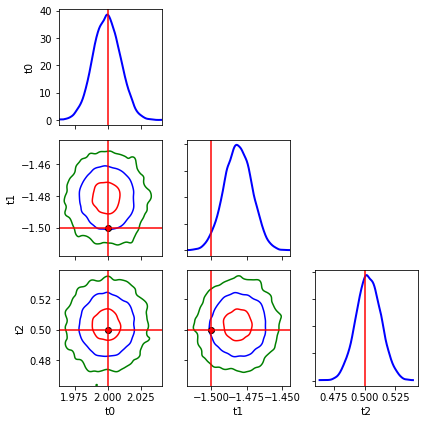

In [155]:
plot_params_kde(data_1, figsize=(6,6),limits=None,
  point_estimate=None, reference_values=truth, reference_color='r');